In this notebook, we'll go through some exploratory data analysis, visualize these data points to gain deeper insights, and then build the cost function according to the problem formulation and do a bit of a search for the optimum.

# The Problem
![Santa](https://i.imgur.com/reXzZWf.jpg)

Santa's worhshop runs like a well-oiled machine and the accountants run a tight ship. Let's have a look at how we can accommodate as many families as possible without breaking the bank entirely.

## The Deets:
- 5,000 families
-   100 days
- 125 to 300 per day (hard limit)

## The Costs:
### Consolation Gifts:

This should be interesting to look at. Every choice has a cost and the lower we go in priority, the more gratuitous we get with the families. Look at `9` and `++` getting helicopter rides for each person. Ooph!

| `choice` | Gift Card  | Buffet  | Helicopter |
|----------|------------|---------|------------|
|          | (fixed)    | (per P) | (per P)    |
| 0        | 0          | 0       | 0          |
| 1        | 50         | 0       | 0          |
| 2        | 50         | 9       | 0          |
| 3        | 100        | 9       | 0          |
| 4        | 200        | 9       | 0          |
| 5        | 200        | 18      | 0          |
| 6        | 300        | 18      | 0          |
| 7        | 300        | 36      | 0          |
| 8        | 400        | 36      | 0          |
| 9        | 500        | 36      | 199        |
| ++       | 500        | 36      | 398        |

### Accounting:
Accounting runs a tight, recursive ship. $N_d$ is the number of occupants on the day $d$. Starting 100 days before, working your way towards Christmas.

$$\text{accounting penalty} = \sum\limits_{d=100}^1 \frac{N_d - 125}{400} \cdot N_d^{\left(0.5 + \frac{\left|N_d - N_{d+1}\right|}{50}\right)}$$

## Sources:

Blatantly copying stuff from these notebooks. Give them an upvote!

- https://www.kaggle.com/inversion/santa-s-2019-starter-notebook (Get a good initial idea)
- https://www.kaggle.com/chewzy/santa-finances-a-closer-look-at-the-costs (Nice EDA)
- https://www.kaggle.com/nickel/santa-s-2019-fast-pythonic-cost-23-s (Really fast Pythonic cost, which I adapted)
- https://www.kaggle.com/xhlulu/santa-s-2019-stochastic-product-search (Great impementation of random search, which I adapted)
- https://www.kaggle.com/ilu000/greedy-dual-and-tripple-shuffle-with-fast-scoring (Better data, which I'm using in the newer kernels.)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit
from itertools import product
from time import time
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
start_time = time()
end_time = start_time + (7.5 *60 *60)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/santa-s-2019-stochastic-product-search/__notebook__.ipynb
/kaggle/input/santa-s-2019-stochastic-product-search/__results__.html
/kaggle/input/santa-s-2019-stochastic-product-search/__output__.json
/kaggle/input/santa-s-2019-stochastic-product-search/__resultx__.html
/kaggle/input/santa-s-2019-stochastic-product-search/custom.css
/kaggle/input/santa-s-2019-stochastic-product-search/submission_76177.csv
/kaggle/input/santa-workshop-tour-2019/family_data.csv
/kaggle/input/santa-workshop-tour-2019/sample_submission.csv


In [2]:
fpath = '/kaggle/input/santa-workshop-tour-2019/family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = '/kaggle/input/santa-workshop-tour-2019/sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

fpath = '/kaggle/input/santa-s-2019-stochastic-product-search/submission_76177.csv'
prediction = pd.read_csv(fpath, index_col='family_id').assigned_day.values

In [3]:
family_sizes = data.n_people.values.astype(np.int8)

# Families Visualized
Quick look at the data and the distribution of family sizes and all that jazz. The families seem to be be mostly smaller than 5 families, and most would like to go right before Christmas, let's dive in:

In [4]:
data.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [5]:
print("Average number of people per day:", sum(data['n_people'])//100)

Average number of people per day: 210


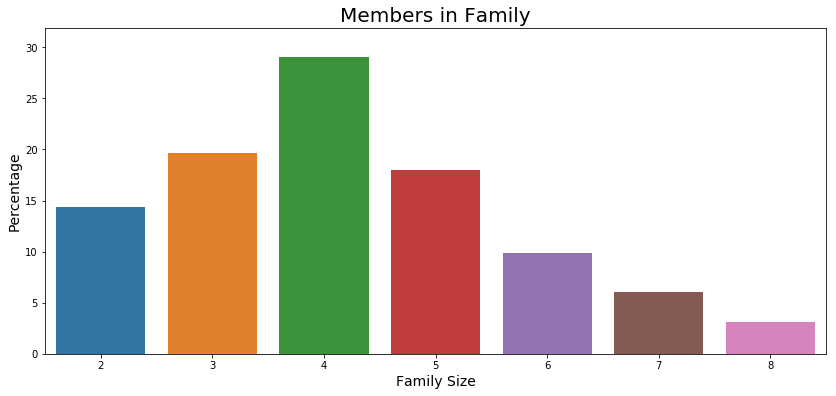

In [6]:
family_size = data['n_people'].value_counts().sort_index()
family_size /= 50

plt.figure(figsize=(14,6))
ax = sns.barplot(x=family_size.index, y=family_size.values)

ax.set_ylim(0, 1.1*max(family_size))
plt.xlabel('Family Size', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.title('Members in Family', fontsize=20)
plt.show()

No surprises there. Most families between 2 and 5 with 4 being the highest. Some families in the long tail, sadly lacking information whether they're catholic.

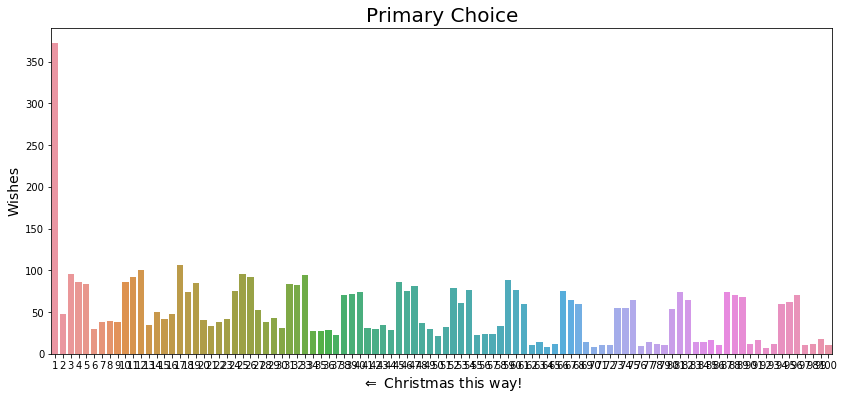

In [7]:
fave_day = data['choice_0'].value_counts().sort_index()

plt.figure(figsize=(14,6))
ax = sns.barplot(x=fave_day.index, y=fave_day.values)


plt.xlabel('$\Leftarrow$ Christmas this way!', fontsize=14)
plt.ylabel('Wishes', fontsize=14)
plt.title('Primary Choice', fontsize=20)
plt.show()

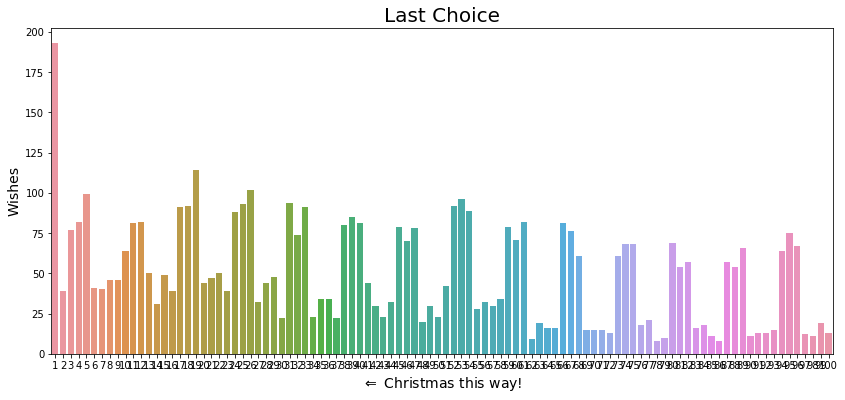

In [8]:
ninthfave_day = data['choice_9'].value_counts().sort_index()

plt.figure(figsize=(14,6))
ax = sns.barplot(x=ninthfave_day.index, y=ninthfave_day.values)


plt.xlabel('$\Leftarrow$ Christmas this way!', fontsize=14)
plt.ylabel('Wishes', fontsize=14)
plt.title('Last Choice', fontsize=20)
plt.show()

So, Christmas day is the most wished for clearly. In between there are the weekends pretty steady. The weekday wishes decrease towards the farther days. This holds for the first as much as the last.

Let's look at some costs:

# Costs Visualized
Set up a dict, because they're cheap and we only need two values accessible. We can use this one for later hopefully. Array would probably be fine though. I'm no software engineer.

In [9]:
cost_dict = {0:  [  0,  0],
             1:  [ 50,  0],
             2:  [ 50,  9],
             3:  [100,  9],
             4:  [200,  9],
             5:  [200, 18],
             6:  [300, 18],
             7:  [300, 36],
             8:  [400, 36],
             9:  [500, 36 + 199],
             10: [500, 36 + 398],
            }

def cost(choice, members, cost_dict):
    x = cost_dict[choice]
    return x[0] + members * x[1]

Let's look at all the costs for each choice for each family. In the image, I'm dropping the choices `0` and `1`, because they're boring (constant for any number of members). 

It's really clear there is a big cliff for `choice_9` and `otherwise`, helicopters gonna helicopter.

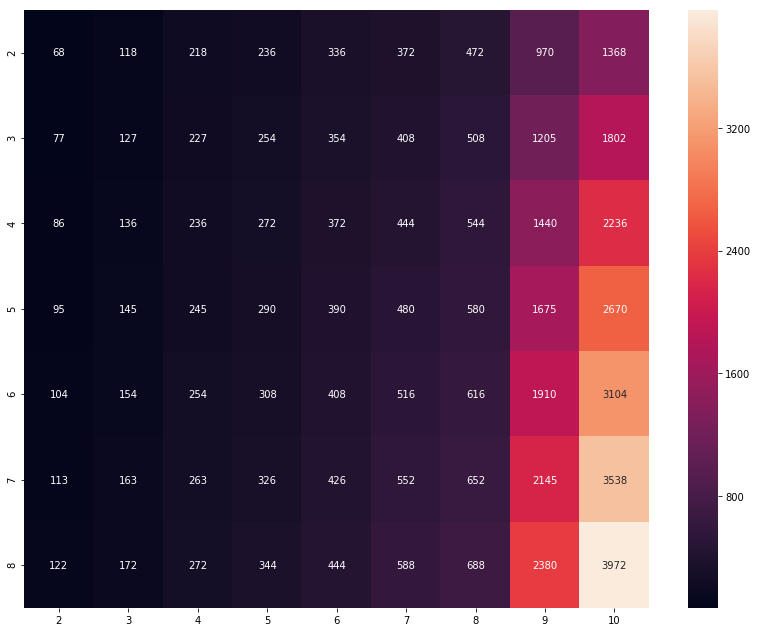

In [10]:
all_costs = {k: pd.Series([cost(k, x, cost_dict) for x in range(2,9)], index=range(2,9)) for k in cost_dict.keys()}
df_all_costs = pd.DataFrame(all_costs)
plt.figure(figsize=(14,11))
sns.heatmap(df_all_costs.drop([0, 1],axis=1), annot=True, fmt="g")

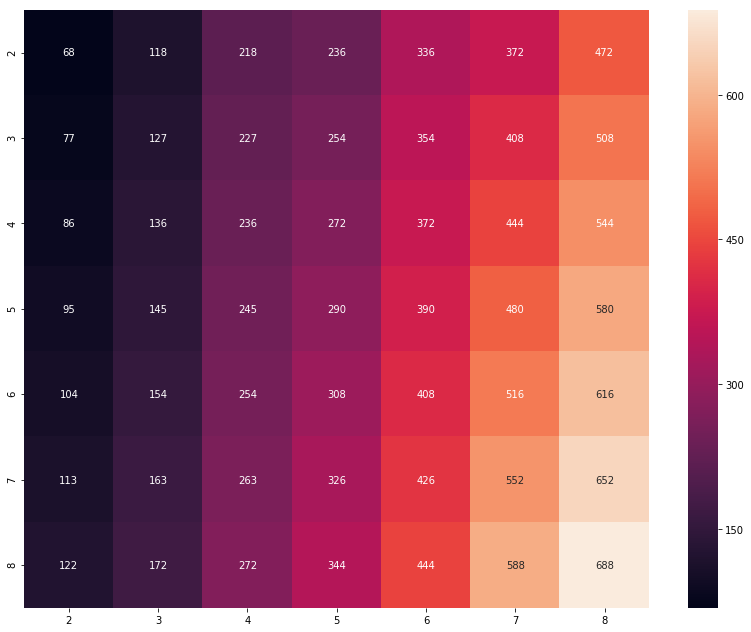

In [11]:
plt.figure(figsize=(14,11))
sns.heatmap(df_all_costs.drop([0, 1, 9, 10],axis=1), annot=True, fmt="g")

We need this one to get a quick cost calculation and to be quite honest, we don't need to look at it technically, but the barcode is kinda cool:

In [12]:
family_cost_matrix = np.zeros((100,len(family_sizes))) # Cost for each family for each day.

for i, el in enumerate(family_sizes):
    family_cost_matrix[:, i] += all_costs[10][el] # populate each day with the max cost
    for j, choice in enumerate(data.drop("n_people",axis=1).values[i,:]):
        family_cost_matrix[choice-1, i] = all_costs[j][el] # fill wishes into cost matrix

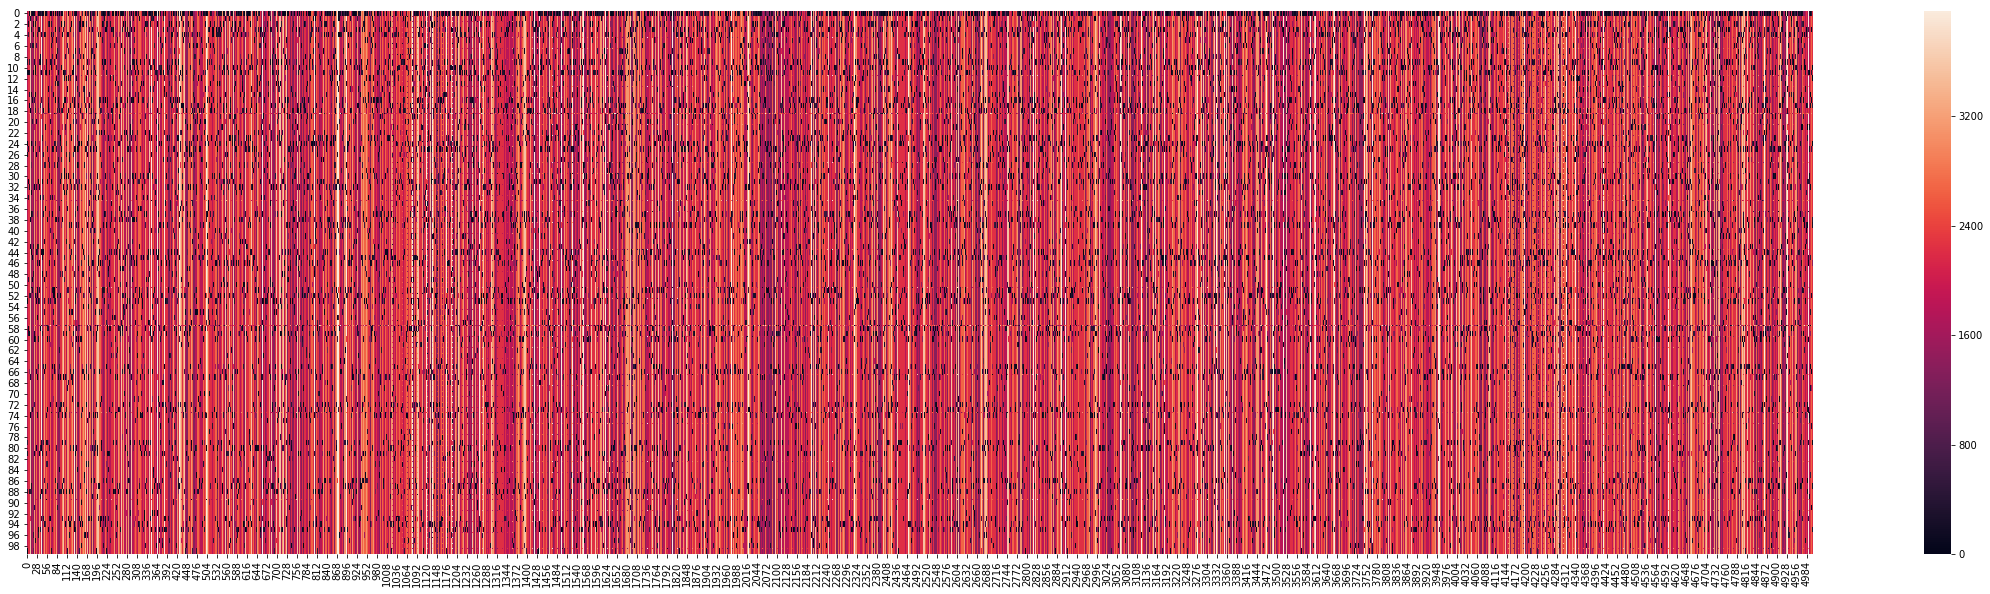

In [13]:
plt.figure(figsize=(40,10))
sns.heatmap(family_cost_matrix)
plt.show()

# Accounting Visualized
It seems accounting can throw us off a bit. I cliped it to 4k similar to the gift-cards to make a point. But if you go to the maximum in the corner, the cost easily outpaces paying off every family to stay home.

That's why you always take care off accounting.

In [14]:
def accounting(today, previous):
    return ((today - 125) / 400 ) * today ** (.5 + (abs(today - previous) / 50))

The maximum cost is a ridiculous: 3543750000.0


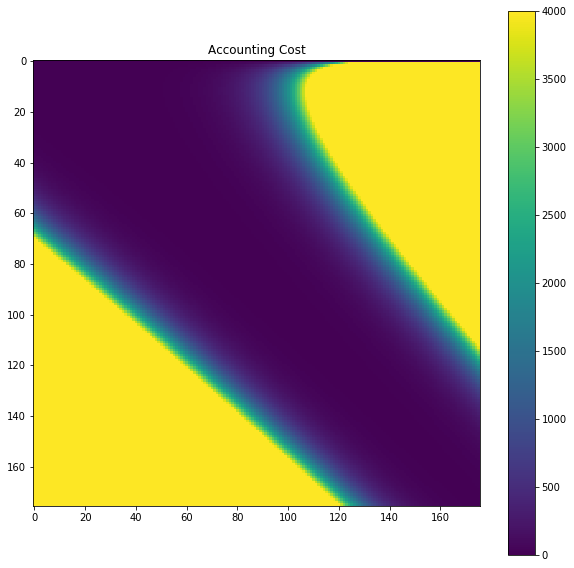

In [15]:
acc_costs = np.zeros([176,176])

for i, x in enumerate(range(125,300+1)):
    for j, y in enumerate(range(125,300+1)):
        acc_costs[i,j] = accounting(x,y)

plt.figure(figsize=(10,10))
plt.imshow(np.clip(acc_costs, 0, 4000))
plt.title('Accounting Cost')
plt.colorbar()

print("The maximum cost is a ridiculous:", acc_costs.max())

# Optimized Cost Function [22μs]
This means we can now look up all of the costs for the actual optimization.

Everyone would love to come on the weekend and of course on the day before Christmas, but ideally we should smooth it out somehow, so accounting doesn't bite us.

In [16]:
@njit(fastmath=True)
def cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix):
    N_DAYS = 100
    MAX_OCCUPANCY = 300
    MIN_OCCUPANCY = 125
    penalty = 0
    accounting_cost = 0
    max_occ = False
    
    daily_occupancy = np.zeros(N_DAYS + 1, dtype=np.int16)
    for i, (pred, n) in enumerate(zip(prediction, family_size)):
        daily_occupancy[pred - 1] += n
        penalty += family_cost_matrix[pred - 1, i]
        
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_next = daily_occupancy[day + 1]
        n = daily_occupancy[day]
        max_occ += MIN_OCCUPANCY > n
        max_occ += MAX_OCCUPANCY < n
        accounting_cost += accounting_cost_matrix[n-MIN_OCCUPANCY, n_next-MIN_OCCUPANCY]
    if max_occ: 
        return 1e11
    return penalty + accounting_cost

In [17]:
cost_function(prediction, family_sizes, family_cost_matrix, acc_costs)

76177.27504576276

In [18]:
%timeit cost_function(prediction, family_sizes, family_cost_matrix, acc_costs)

22.5 µs ± 350 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Aw yiss. Thanks Crescenzi. I did choose not to return an array, but just a single cost, which apparently shaves off another $\mu s$, not sure if that matters. Let's use the [stochastic product search](https://www.kaggle.com/xhlulu/santa-s-2019-stochastic-product-search/data), because it seems really cool. Let's do two long rounds as well, this is a slight modification not using tqdm, I think more modifications would be great to make it work even better.

# Versatile Stochastic Search

In [19]:
def stochastic_product_search(original, choice_matrix, top_k=2, num_fam=8, 
                              n_time=None, n_iter=None, early_stop=np.inf,
                              decrease=np.inf, random_state=42, verbose=1e4):
    """Randomly sample families, reassign and evaluate.
    
    At every iterations, randomly sample num_fam families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^num_fam products.
    
    Both n_time and n_iter can be set, optimization stops when first one is reached.
    
    Arguments:
        original {1d Array} -- Initial assignment of families
        choice_matrix {2d Array} -- Choices of each family
    
    Keyword Arguments:
        top_k {int} -- Number of choices to include (default: {2})
        num_fam {int} -- Number of families to sample (default: {8})
        n_time {int} -- Maximum execution time (default: {None})
        n_iter {int} -- Maximum number of executions (default: {None})
        early_stop {int} -- Stop after number of stagnant iterations (default: {np.inf})
        decrease {int} -- Decrease num_fam after number of stagnant iterations (default: {np.inf})
        random_state {int} -- Set NumPy random state for reproducibility (default: {42})
        verbose {int} -- Return current best after number of iterations (default: {1e4})
    
    Example:
        best = stochastic_product_search(
        choice_matrix=data.drop("n_people", axis=1).values, 
        top_k=3,
        num_fam=16, 
        original=prediction,
        n_time=int(3600),
        n_iter=int(1e5),
        early_stop=5e6,
        decrease=5e4,
        verbose=int(5e3),
        )
    
    Returns:
        [1d Array] -- Best assignment of families
    """
    np.random.seed(random_state)
    
    i = 0
    early_i = 0
    opt_time = time()  
    
    if n_time:
        max_time = opt_time + n_time
    else:
        max_time = opt_time
    
    if n_iter:
        max_iter = n_iter
    else:
        max_iter = 0
    
    best = original.copy()
    best_score = cost_function(best, family_sizes, family_cost_matrix, acc_costs)
    
    while ((max_time - time() > 0) or (not n_time)) and ((i < max_iter) or (not n_iter)) and (early_i < early_stop):
        fam_indices = np.random.choice(choice_matrix.shape[0], size=num_fam)
        
        for change in np.array(np.meshgrid(*choice_matrix[fam_indices, :top_k])).T.reshape(-1,num_fam):
            new = best.copy()
            new[fam_indices] = change

            new_score = cost_function(new, family_sizes, family_cost_matrix, acc_costs)

            if new_score < best_score:
                best_score = new_score
                best = new
                early_i = 0
            else:
                early_i += 1/num_fam
        
        if (early_i > decrease) and (num_fam > 2):
            num_fam -= 1
            early_i = 0
            if verbose:
                print(f"Decreasing sampling size to {num_fam}.")
                
            
        if verbose and i % verbose == 0:
            print(f"Iteration {i:05d}:\t Best score is {best_score:.2f}\t after {(time()-opt_time)//60:.0f} minutues {(time()-opt_time)%60:.0f} seconds.")
        i += 1
    
    print(f"Final best score is {best_score:.2f} after {(time()-opt_time)//60:.0f} minutues {(time()-opt_time)%60:.0f} seconds.")
    print(f"Each loop took {1000*(time()-opt_time)/i:.2f} ms.")
    return best

This is just a quick demonstration for the kernel:

In [20]:
best = stochastic_product_search(
    prediction,
    choice_matrix=data.drop("n_people", axis=1).values, 
    top_k=1,
    num_fam=32, 
    n_time=int(60),
    early_stop=5e6,
    decrease=5e4,
    verbose=int(5e3),
)

Iteration 00000:	 Best score is 76177.28	 after 0 minutues 0 seconds.
Iteration 05000:	 Best score is 76177.28	 after 0 minutues 3 seconds.
Iteration 10000:	 Best score is 76177.28	 after 0 minutues 6 seconds.
Iteration 15000:	 Best score is 76177.28	 after 0 minutues 8 seconds.
Iteration 20000:	 Best score is 76177.28	 after 0 minutues 11 seconds.
Iteration 25000:	 Best score is 76177.28	 after 0 minutues 14 seconds.
Iteration 30000:	 Best score is 76177.28	 after 0 minutues 17 seconds.
Iteration 35000:	 Best score is 76177.28	 after 0 minutues 20 seconds.
Iteration 40000:	 Best score is 76177.28	 after 0 minutues 23 seconds.
Iteration 45000:	 Best score is 76177.28	 after 0 minutues 25 seconds.
Iteration 50000:	 Best score is 76177.28	 after 0 minutues 28 seconds.
Iteration 55000:	 Best score is 76177.28	 after 0 minutues 31 seconds.
Iteration 60000:	 Best score is 76177.28	 after 0 minutues 33 seconds.
Iteration 65000:	 Best score is 76177.28	 after 0 minutues 36 seconds.
Iteration 

Now let's just bundle this up and send it off to the elves.

In [21]:
submission['assigned_day'] = best
final_score = cost_function(best, family_sizes, family_cost_matrix, acc_costs)
submission.to_csv(f'submission_{int(final_score)}.csv')

## Happy Kaggling
I think we can clearly improve this further, large families seem quite costly and there's a trade-off between caching solutions and simply calculating them, considering the optimization of the cost function. Nevertheless, random search seems to be a pretty good fit for this problem. Maybe Genetic algorithms would also work. Either way, this is a small overview over the data analysis. 

Don't forget to upvote the other kernels, they did amazing work.